# Running PARC for clustering analysis of Covid-19 scRNA cells

### Introduction
Parc is a fast clustering algorithm designed to effectively cluster heterogeneity in large single cell data. We show how PARC enables downstream analysis on the recent dataset published by [Liao. et al (2020)](https://www.nature.com/articles/s41591-020-0901-9)

### Load Libraries

In [1]:
import matplotlib.pyplot as plt
import warnings
from numba.errors import NumbaPerformanceWarning
import numpy as np
import pandas as pd
import scanpy as sc
import parc
import harmonypy as hm

### Load Data

The data is available on [GEO GSE145926](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE145926) with each of the 12 patients in a separate .h5 file. 
The result should be a matrix of shape (n_cells x n_genes) (108230, 33538).

In [2]:
datadir = "/home/shobi/Thesis/Data/Covid/GSE145926_RAW/"
file_batches = ['GSM4475051_C148_filtered_feature_bc_matrix.h5','GSM4475052_C149_filtered_feature_bc_matrix.h5','GSM4475053_C152_filtered_feature_bc_matrix.h5','GSM4475048_C51_filtered_feature_bc_matrix.h5','GSM4475049_C52_filtered_feature_bc_matrix.h5','GSM4339769_C141_filtered_feature_bc_matrix.h5','GSM4339770_C142_filtered_feature_bc_matrix.h5','GSM4339771_C143_filtered_feature_bc_matrix.h5','GSM4339772_C144_filtered_feature_bc_matrix.h5','GSM4475050_C100_filtered_feature_bc_matrix.h5','GSM4339773_C145_filtered_feature_bc_matrix.h5','GSM4339774_C146_filtered_feature_bc_matrix.h5']
patient_type =['S4','S5','S6','HC1','HC2','M1','M2','S2','M3','HC3','S1','S3']
patient_health = ['S','S','S','H','H','M','M','S','M','H','S','S']

for i in range(0,len(patient_type)):
    if i ==0:
        adata = sc.read_10x_h5('/home/shobi/Thesis/Data/Covid/GSE145926_RAW/'+file_batches[i])
        adata.obs['patient_type'] = [patient_type[i] for i_range in range(adata.shape[0])]
        adata.obs['patient_health'] = [patient_health[i] for i_range in range(adata.shape[0])]
        adata.var_names_make_unique()
        
    else:
        temp = sc.read_10x_h5('/home/shobi/Thesis/Data/Covid/GSE145926_RAW/'+file_batches[i] )
        temp.var_names_make_unique()
        temp.obs['patient_type'] = [patient_type[i] for i_range in range(temp.shape[0])]
        temp.obs['patient_health'] = [patient_health[i] for i_range in range(temp.shape[0])]
        adata = adata.concatenate(temp, join='inner') #we want the genes in common
   

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, making a copy.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, making a copy.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, making a copy.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, making a copy.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, making a copy.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, making a copy.
Variab

### Filtering and pre-processing

Following the filters used by Liao et.al (2020) and removing cells with mitochondrial gene proportion > 0.1. 
After filtering the n_cells = 63753 and n_genes = 25668.

In [3]:
min_cells=3 
min_genes=200
max_genes = 6000
min_counts=1000
n_top_genes=2000
n_comps_pca= 50

sc.pp.filter_genes(adata, min_cells=min_cells)  # only consider genes expressed in more than min_cells
sc.pp.filter_cells(adata, min_genes=min_genes) #only consider cells with more than min_genes
sc.pp.filter_cells(adata,max_genes=max_genes) #only consider cells with less than max_cells
sc.pp.filter_cells(adata, min_counts=min_counts) #only consider cells with more than min_counts

mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1/ np.sum(adata.X, axis=1).A1
adata = adata[adata.obs.percent_mito < 0.1, :] #filter cells with high mito

adata.obs['n_counts'] = adata.X.sum(axis=1).A1 #add the total counts per cell as observations-annotation to adata

print('shape after filtering', adata.shape)

sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all' )# normalize with total UMI count per cell
sc.pp.log1p(adata)
adata.raw = adata
#select HVG
filter_result = sc.pp.filter_genes_dispersion(adata.X, flavor='cell_ranger', n_top_genes=n_top_genes, log=False ) # select highly-variable genes
adata = adata[:, filter_result.gene_subset]  # subset the genes

sc.pp.scale(adata, max_value=5)  # scale to unit variance and shift to zero mean. Clip values exceeding standard deviation 10.
sc.tl.pca(adata, svd_solver='arpack', n_comps=n_comps_pca)



Trying to set attribute `.obs` of view, making a copy.


shape after filtering (63753, 25668)


/home/shobi/anaconda3/envs/ViaEnv/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:909: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
2020-05-22 17:07:09,768 - harmonypy - INFO - Iteration 1 of 10
2020-05-22 17:07:25,546 - harmonypy - INFO - Iteration 2 of 10
2020-05-22 17:07:41,288 - harmonypy - INFO - Iteration 3 of 10
2020-05-22 17:07:57,341 - harmonypy - INFO - Converged after 3 iterations


size of harmony corrected output (63753, 50) <class 'numpy.ndarray'>
input data has shape 63753 (samples) x 50 (features)
knn struct was not available, so making one
commencing local pruning based on Euclidean distance metric at 3 s.dev above mean
commencing global pruning
commencing community detection
partition type MVP
list of cluster labels and populations 26 [(0, 10325), (1, 10216), (2, 8257), (3, 7178), (4, 3541), (5, 3186), (6, 2807), (7, 2678), (8, 2663), (9, 2442), (10, 1460), (11, 1127), (12, 1113), (13, 1074), (14, 1070), (15, 882), (16, 875), (17, 799), (18, 726), (19, 526), (20, 226), (21, 189), (22, 156), (23, 138), (24, 54), (25, 45)]
time elapsed 45.6 seconds


### Harmony PCA to integrate the batches

In [ ]:
df_meta = pd.DataFrame()
df_meta['patient_type'] = adata.obs['patient_type']
harmony_out = hm.run_harmony(adata.obsm['X_pca'], df_meta, 'patient_type')
res = harmony_out.Z_corr.T
print('size of harmony corrected output', res.shape, type(res))


### Run PARC clustering

input data has shape 63753 (samples) x 50 (features)
knn struct was not available, so making one
commencing local pruning based on Euclidean distance metric at 3 s.dev above mean
commencing global pruning
commencing community detection
partition type MVP


... storing 'parc' as categorical


list of cluster labels and populations 26 [(0, 10325), (1, 10216), (2, 8257), (3, 7178), (4, 3541), (5, 3186), (6, 2807), (7, 2678), (8, 2663), (9, 2442), (10, 1460), (11, 1127), (12, 1113), (13, 1074), (14, 1070), (15, 882), (16, 875), (17, 799), (18, 726), (19, 526), (20, 226), (21, 189), (22, 156), (23, 138), (24, 54), (25, 45)]
time elapsed 46.7 seconds
Plot cluster average expression of marker genes


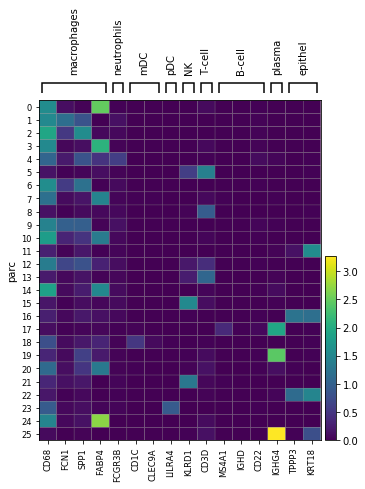

a,b, spread, dist 1.576943460405378 0.8950608781227859 1.0 0.1
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
completed embedding


In [33]:
p = parc.PARC(res, random_seed=42)
p.run_PARC()
adata.obs['parc'] = [str(i) for i in p.labels]

marker_genes = {"macrophages": ['CD68','FCN1','SPP1','FABP4'], "neutrophils": ['FCGR3B'],
                "mDC": ['CD1C', 'CLEC9A'], "pDC": ['LILRA4'],
                "NK": ['KLRD1'], 'T-cell': ['CD3D'], 'B-cell': ['MS4A1','IGHD', 'CD22'], 'plasma': ['IGHG4'], #CD19 doesnt show up for B
                'epithel': ['TPPP3', 'KRT18']}

print('Plot cluster average expression of marker genes')
ax_mat = sc.pl.matrixplot(adata, marker_genes, groupby='parc')
graph = p.knngraph_full()
embedding= p.run_umap_hnsw(res, graph, random_state = 1)
print('completed embedding')



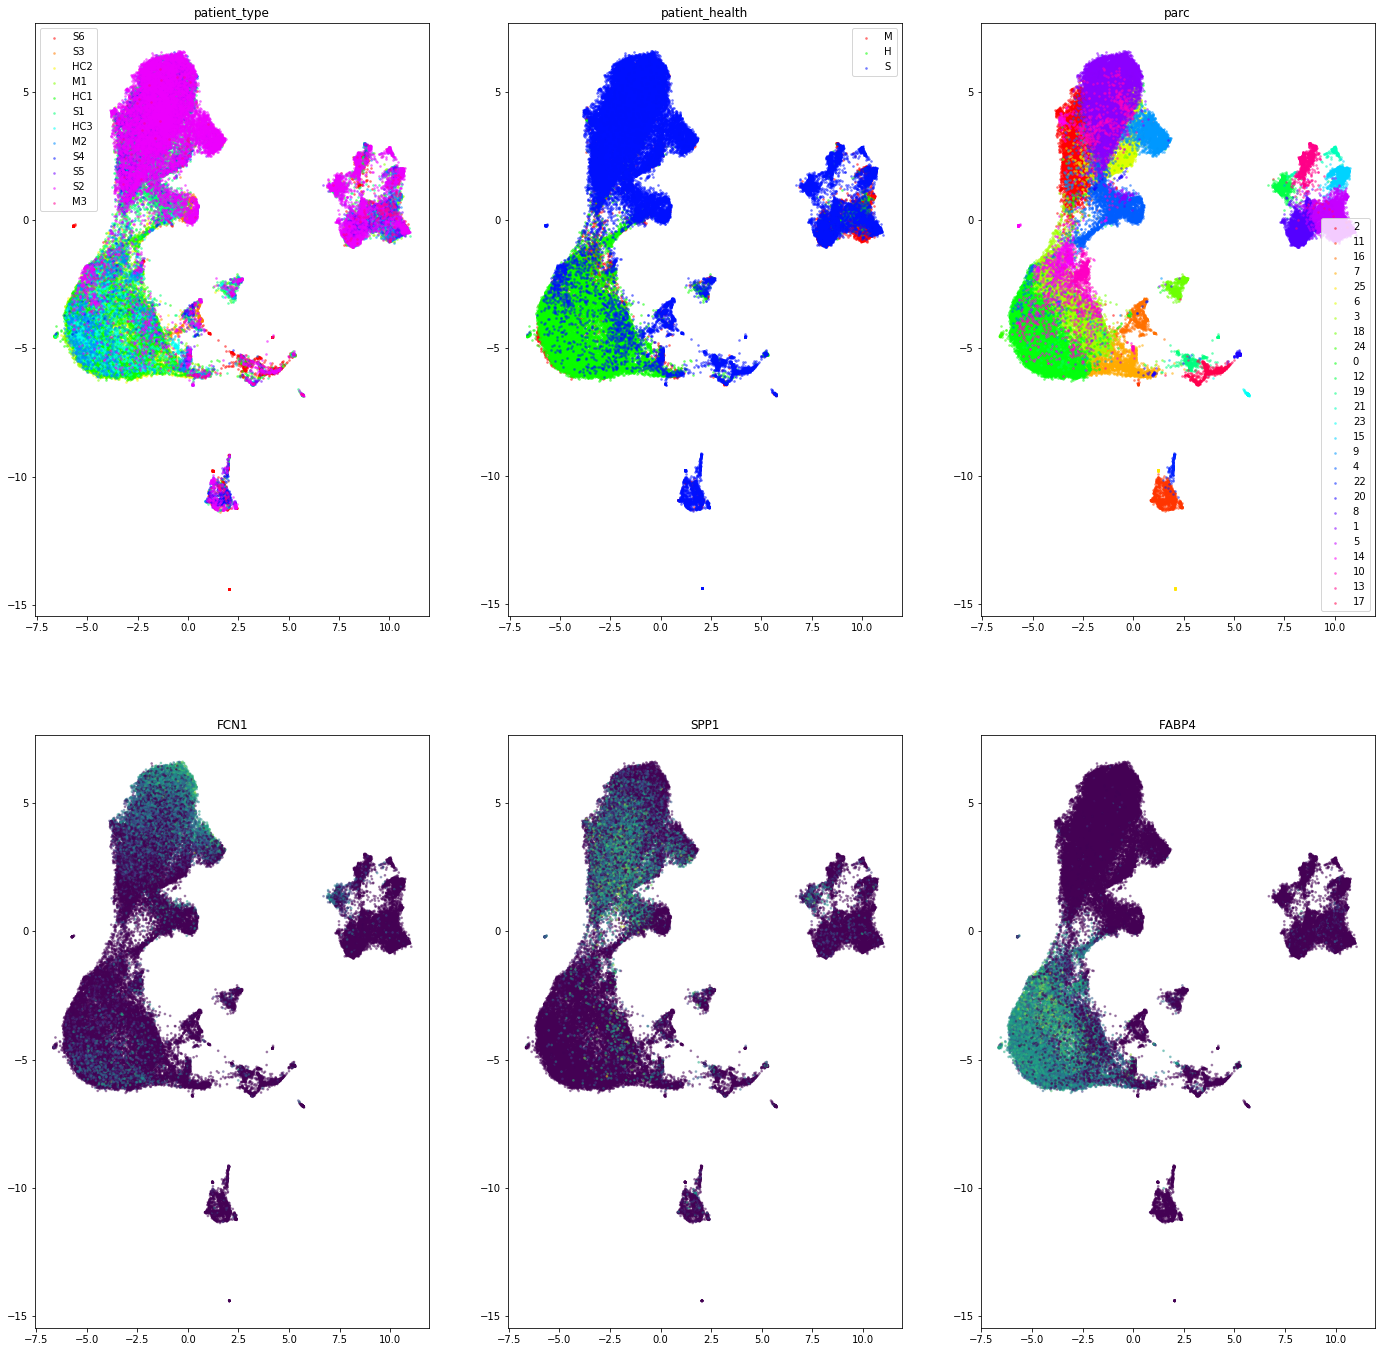

In [32]:
color_views = ['FCN1','SPP1','FABP4']

fig, axs = plt.subplots(2,3 ,figsize=(24,24))
for i in range(3):
    axs[1,i].scatter(embedding[:,0], embedding[:,1], c = adata[:,color_views[i]].X.flatten(), alpha=0.4, s =3)
    axs[1,i].set_title(color_views[i])

color_views_categ = ['patient_type', 'patient_health', 'parc']

import matplotlib.colors as colors
import matplotlib.cm as cmx
for i_ax in range(3):
    uniq = list(set(adata.obs[color_views_categ[i_ax]]))
    # Set the color map to match the number of species
    z = range(1,len(uniq))
    hot = plt.get_cmap('hsv')
    cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap='hsv')
    # Plot each species
    for i in range(len(uniq)):

        indx = adata.obs[color_views_categ[i_ax]] == uniq[i]
        axs[0,i_ax].scatter(embedding[indx,0], embedding[indx,1], color =scalarMap.to_rgba(i), label=uniq[i], alpha=0.4, s =3)
    axs[0,i_ax].set_title(color_views_categ[i_ax])
    axs[0,i_ax].legend()

plt.show()
